In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
from ipywidgets import widgets
import ConfigReader as cr

In [2]:
idx = pd.IndexSlice

#Styles
sns.set_style('darkgrid')
sns.set_color_codes()
plt.rcParams['figure.figsize'] = (12.0, 9.0)

plt.rc('text', usetex=False)
plt.rc('font', size=20.0, family='serif')

In [3]:
# Data location and scenario
data_dir = '../../Experiments_results/autonet_0305_benchmark/results/experiment'
dataset = '917_bac'
preprocessor='NoPreprocessing'
fline = 'validationResults-detailed-traj-run-10-walltime.csv'
traj_file = os.path.join(data_dir, dataset, preprocessor, dataset, fline)

In [4]:
os.path.isfile(traj_file)

True

In [65]:
reload(cr)

<module 'ConfigReader' from 'ConfigReader.py'>

In [71]:
reader = cr.ConfigReader(data_dir=data_dir, dataset=dataset)
tdf = reader.load_validation_trajectories(preprocessor=preprocessor, load_config=True)

In [67]:
tdf = reader.load_validation_by_file(traj_file, load_config=True)

In [410]:
tdf.loc[:, ('classifier','num_layers')] = tdf['classifier']['num_layers'].apply(lambda X:ord(X)-ord('a'))

In [220]:
# Start filtering the error
temp_df = tdf.copy()
temp_df.columns = tdf.columns.droplevel(0)
min_perf = temp_df['performance'].min()
mean_perf = temp_df['performance'].mean()
std_perf = temp_df['performance'].std()

In [221]:
m = tdf[('smac', 'performance')]<0.3
#tdf.loc[m]

### Setting values to log scale and categorical values

In [222]:
log_columns = ['beta1', 'beta2', 'gamma', 'lambda2', 'learning_rate', 'momentum','num_units_layer_1',
               'num_units_layer_2', 'num_units_layer_3', 'num_units_layer_4', 'num_units_layer_5',
               'num_units_layer_6', 'power', 'std_layer_1', 'std_layer_2', 'std_layer_3','std_layer_4',
               'std_layer_5', 'std_layer_6']

categorical_cols = ['activation_layer_1', 'activation_layer_2', 'activation_layer_3', 'activation_layer_4',
                    'activation_layer_5', 'activation_layer_6', 'lr_policy', 'num_layers', 'weight_init_1',
                    'weight_init_2', 'weight_init_3', 'weight_init_4', 'weight_init_5', 'weight_init_6']

In [223]:
mask_log_cols = zip(['classifier']*len(log_columns), log_columns)
mask_cat_cols = zip(['classifier']*len(categorical_cols), categorical_cols)

In [419]:
tdf.loc[:, mask_log_cols] = np.log10(tdf.loc[:, mask_log_cols])

In [225]:
for c in mask_cat_cols:
    tdf.loc[:, c] = tdf.loc[:, c].astype('category')

In [226]:
activation_categories = ["elu", "leaky", "linear", "relu", "scaledTanh", "sigmoid", "tanh"]
weight_categories = ['constant', 'normal', 'uniform','glorot_normal', 'glorot_uniform',
                     'he_normal', 'he_uniform', 'ortogonal', 'sparse']
policies_categories = ['fixed', 'inv', 'exp', 'step']

In [324]:
tdf.loc[:, ('classifier', 'lr_policy')].value_counts()

inv      56
fixed    45
step     25
exp       6
dtype: int64

## After Setting the frames. Start with the plotting

In [411]:
# Plot the empirical CDF
sorted_Y = (tdf.sort_values(by=('smac','performance'), ascending=True).loc[:,('smac','performance')].values)
yvals = np.arange(len(sorted_Y)) / float(len(sorted_Y))

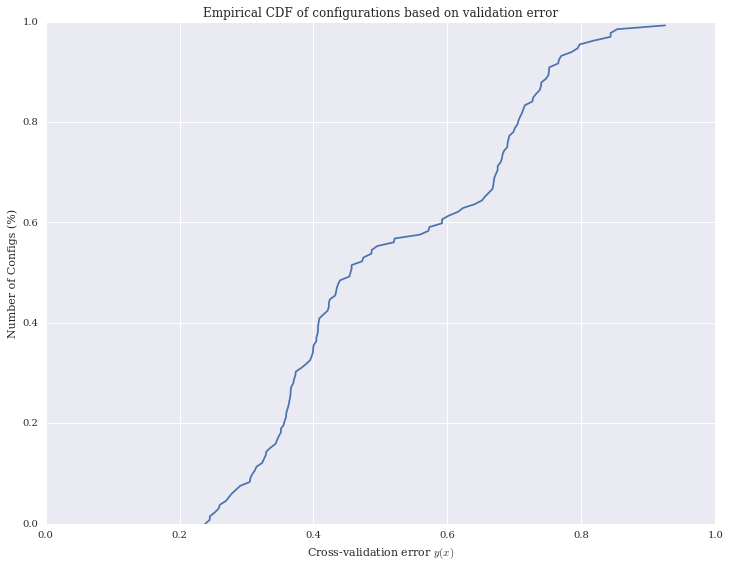

In [412]:
plt.plot( sorted_Y, yvals )
plt.xlabel("Cross-validation error $y(x)$")
plt.ylabel(r"Number of Configs (%)")
plt.xlim(0.0, 1.0)
plt.title("Empirical CDF of configurations based on validation error")
plt.show()

In [413]:
def plotting_threshold(error_threshold, categories):
    mask_filter = tdf[('smac','performance')] <= error_threshold
    filtered = tdf[mask_filter]
    fig_f, axs = plt.subplots(ncols=2,nrows=1, figsize=(15.0, 8.5))
    ax0, ax1 = axs.flat
    sns.boxplot(x=categories, y=('smac','performance'), data=filtered, ax=ax0)
    sns.countplot(y=categories, data=filtered, ax=ax1)
    fig_f.tight_layout()

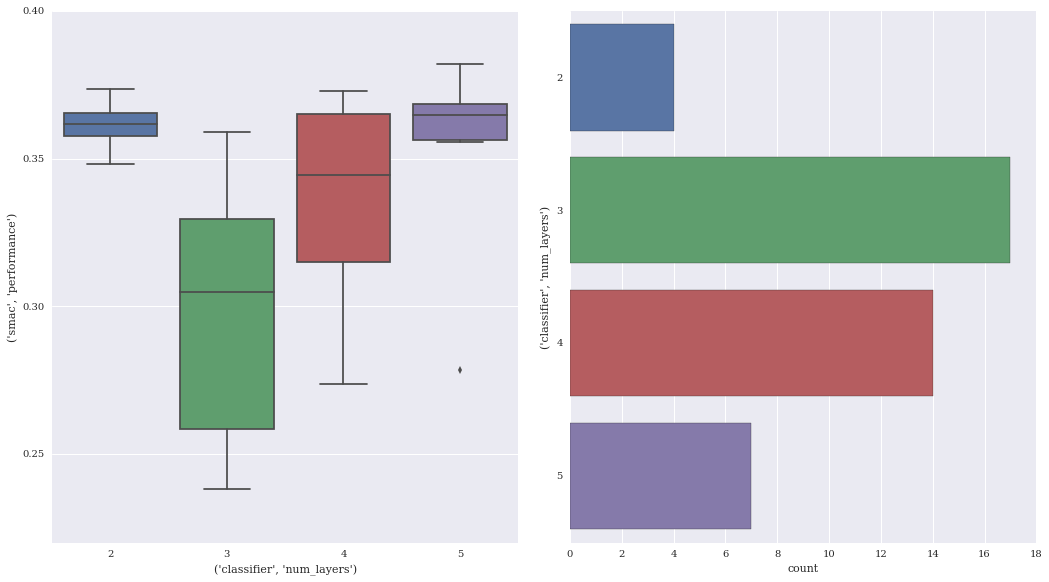

In [414]:
widgets.interact(plotting_threshold, error_threshold=(min_perf,mean_perf + std_perf, 0.01),
                 categories={'Solver':('classifier','solver'), 'Policy':('classifier','lr_policy'),
                             'Number of layers':('classifier','num_layers')})

### Plot distro over learning rates

In [421]:
# Create the grouping of the filtered DF
classifier_df = tdf['classifier']
solver_filt = classifier_df.groupby('solver')

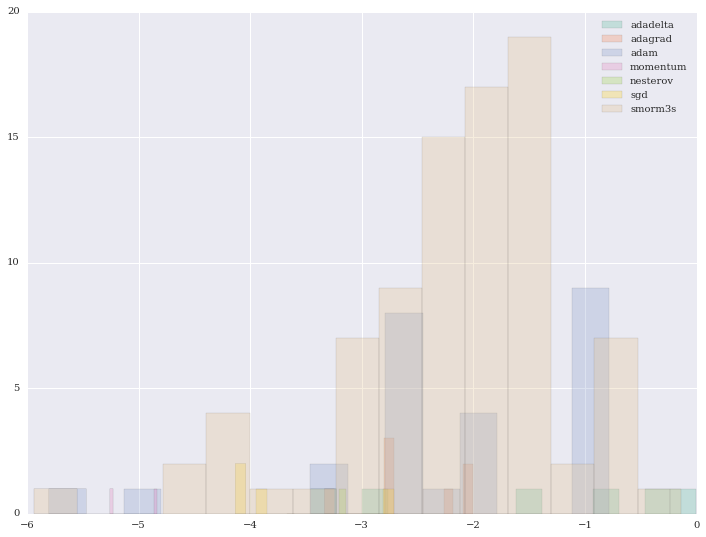

In [422]:
# Seaborns Normed Distribution plots
with sns.color_palette('Set2',7):
    for name,groups in solver_filt:
        #sns.distplot(groups.learning_rate, bins=6, kde_kws={'label':name, 'bw':0.019})
        #sns.distplot(groups.learning_rate, kde=False, bins=6, hist_kws={'label':name}, norm_hist=False)
        plt.hist(groups.learning_rate.values, alpha=0.3, bins=15, label=name)
    plt.legend()

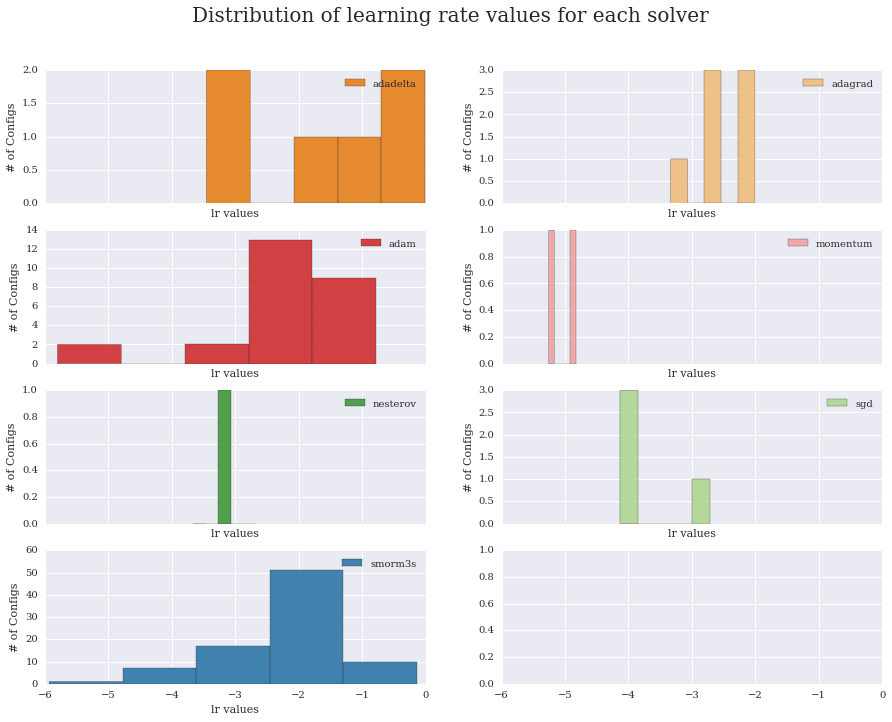

In [423]:
col_hist = sns.color_palette('Paired',8, desat=0.8)
fig2, axs = plt.subplots(nrows=4, ncols=2, sharex=True, figsize=(15.,11.))
fig2.suptitle('Distribution of learning rate values for each solver')
for ax, (name, groups) in zip(axs.flat,solver_filt):
    ax.hist(groups.learning_rate.values, bins=5, histtype='bar', fill=True,
            label=name, alpha=0.9, color=col_hist.pop())
    ax.set_xlabel('lr values')
    ax.set_ylabel('# of Configs')
    ax.legend()

### Plot over different preprocessing methods

In [ ]:
# Create the grouping of the filtered DF
prepro_filt = classifier_df.groupby('preprocessor')

In [ ]:
prepro_color = sns.color_palette('Paired',12, desat=0.8)

fig4, axs = plt.subplots(nrows=5, ncols=2, sharex=True, figsize=(15.,15.))
fig4.suptitle('Distribution of learning rate values for each preprocessing method')
for ax, (name, groups) in zip(axs.flat,prepro_filt):
    ax.hist(groups.learning_rate.values, bins=10, histtype='bar', fill=True, label=name,
            alpha=0.9, color=prepro_color.pop())
    ax.set_xlabel('lr values')
    ax.set_ylabel('# of Configs')
    ax.legend()

### Plot over different solver

In [349]:
def histogram_group_column_plotting(grouping, column):
    g = rt['classifier'].groupby(grouping)
    s = len(g)
    col_hist = sns.color_palette('Paired',s, desat=0.8)
    fig_hist, axs = plt.subplots(nrows=int(np.ceil(s/2.)), ncols=2, sharex='col',
                                 sharey='row', figsize=(15., 11.))
    for ax, (name, groups) in zip(axs.flat, g):
        ax.hist(groups[column].dropna().values, bins=15,
                histtype='bar', fill=True, label=name, alpha=0.9, color=col_hist.pop())
        ax.set_xlabel(column + ' values')
        ax.set_ylabel('# of Configs')
        ax.legend()
    ax = axs.flat[7]
    ax.set_visible(False)
    fig_hist.suptitle('Distribution of '+ column +' values for each '+(grouping))

In [424]:
# Create columns dict
Groups = ['solver', 'lr_policy']
Plott = {'# of Epochs':'number_updates', 'batch size':'batch_size',
         'step (lr_policy)':'epoch_step', 'Gamma':'gamma', 'Lambda':'lambda2', 'learning rate': 'learning_rate',
         'Beta 1':'beta1', 'Beta 2':'beta2', 'Momentum':'momentum', 'Rho':'rho', 'Power':'power',
         'Dropout rate of layer 1':'dropout_layer_1', 'Dropout rate of layer 2':'dropout_layer_2',
         'Dropout rate of layer 3':'dropout_layer_3', 'Dropout rate of layer 4':'dropout_layer_4',
         'Dropout rate of layer 5':'dropout_layer_5', 'Dropout rate at output':'dropout_output'}

IndexError: index 7 is out of bounds for axis 0 with size 4

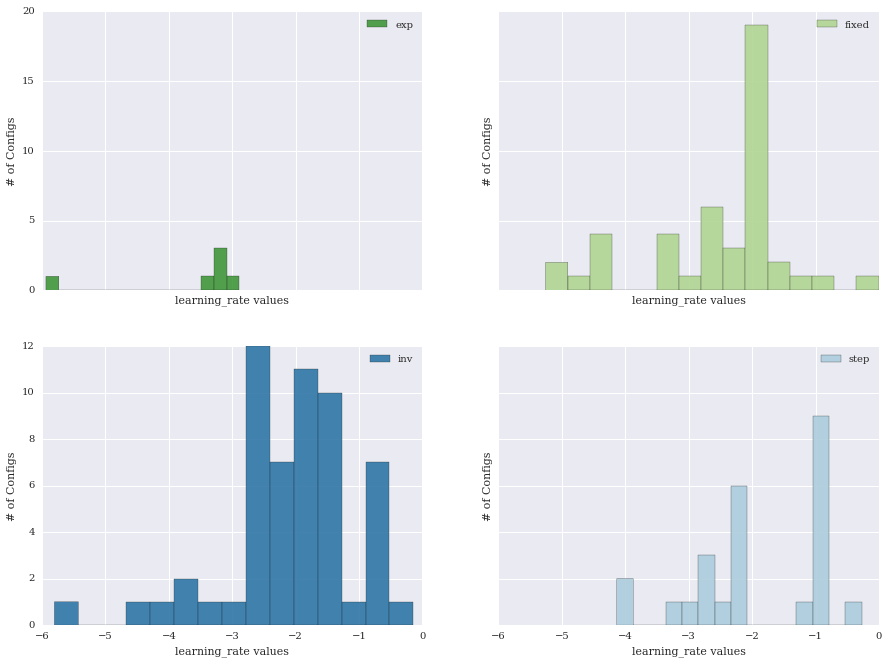

In [425]:
widgets.interact(histogram_group_column_plotting, grouping=Groups, column=Plott)

### Distribution of each parameter over all filtered configurations

In [426]:
def histogram_column_plotting(column):
    #Have to convert the -1 to NaN
    addMissing_df = rt['classifier']
    fig_hist = plt.figure(6)
    ax1 = plt.subplot(111)
    ax1.set_title('Histogram of '+column)
    addMissing_df[column].plot(kind='hist', bins=15, ax=ax1)
    ax1.set_xlabel('values')

In [427]:
non_cat_cols = [item for item in classifier_df.columns.values if item not in categorical_cols]

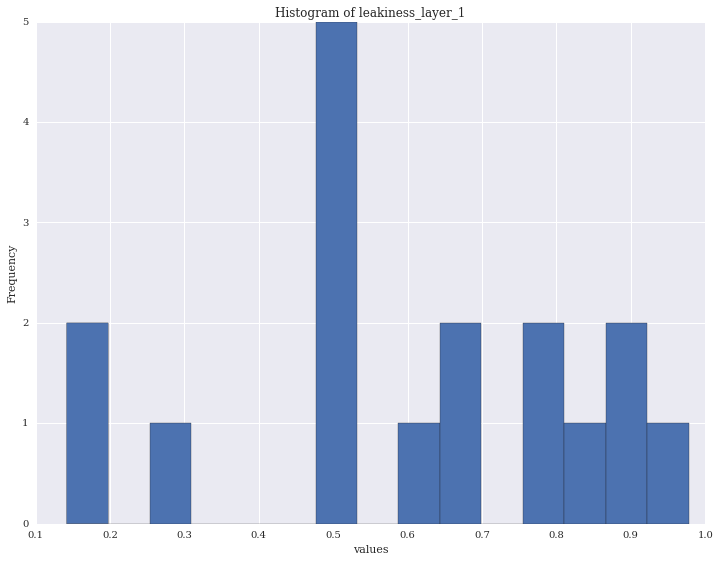

In [428]:
widgets.interact(histogram_column_plotting, column=non_cat_cols)